#### 1. Create a simple data structure to append and store the files.

In [101]:
import pandas as pd
import numpy as np

In [102]:
df1 = pd.read_csv('Stock_trading_2023.csv')
df2 = pd.read_csv('Stock_trading_2024.csv')
df3 = pd.read_csv('Stock_trading_2025.csv')
portfolio_df = pd.concat([df1, df2, df3], ignore_index=True)
portfolio_df.to_csv('combined_trades.csv', index=False)

"""for df in [df1, df2, df3]:
    df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%Y-%m-%d, %H:%M:%S', errors='coerce')
    df.dropna(subset=['Date/Time'], inplace=True)  # Remove rows with invalid dates
    df['Date'] = df['Date/Time'].dt.normalize()   # Keeps date only, drops time"""

"for df in [df1, df2, df3]:\n    df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%Y-%m-%d, %H:%M:%S', errors='coerce')\n    df.dropna(subset=['Date/Time'], inplace=True)  # Remove rows with invalid dates\n    df['Date'] = df['Date/Time'].dt.normalize()   # Keeps date only, drops time"

#### Data Cleaning

In [103]:
portfolio_df.info()
portfolio_df.describe(include='all')
portfolio_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Trades             522 non-null    object 
 1   Header             522 non-null    object 
 2   DataDiscriminator  522 non-null    object 
 3   Asset Category     522 non-null    object 
 4   Currency           522 non-null    object 
 5   Symbol             522 non-null    object 
 6   Date/Time          522 non-null    object 
 7   Quantity           522 non-null    object 
 8   T. Price           522 non-null    float64
 9   C. Price           522 non-null    float64
 10  Proceeds           522 non-null    float64
 11  Comm/Fee           522 non-null    float64
 12  Basis              522 non-null    float64
 13  Realized P/L       522 non-null    float64
 14  MTM P/L            522 non-null    float64
 15  Code               522 non-null    object 
dtypes: float64(7), object(9)
m

,Trades,Header,DataDiscriminator,Asset Category,Currency,Symbol,Date/Time,Quantity,T. Price,C. Price,Proceeds,Comm/Fee,Basis,Realized P/L,MTM P/L,Code
0,Trades,Data,Order,Stocks,USD,AMZN,"2023-07-21, 13:57:21",50,130.4780,130.00,-6523.90,-1.0780,6524.9780,0.0,-23.90,O
1,Trades,Data,Order,Stocks,USD,AMZN,"2023-09-19, 13:30:46",20,136.7100,137.63,-2734.20,-1.0792,2735.2792,0.0,18.40,O;P
2,Trades,Data,Order,Stocks,USD,GOOG,"2023-07-31, 13:11:02",50,132.6600,133.11,-6633.00,-1.0780,6634.0780,0.0,22.50,O
3,Trades,Data,Order,Stocks,USD,GOOG,"2023-10-30, 12:43:40",50,125.4882,125.75,-6274.41,-1.0780,6275.4880,0.0,13.09,O
4,Trades,Data,Order,Stocks,USD,GPRO,"2023-08-24, 09:39:55","2,500",3.9000,3.81,-9750.00,-13.4000,9763.4000,0.0,-225.00,O;P


In [104]:
portfolio_df.isnull().sum()

Trades               415
Header               415
DataDiscriminator    415
Asset Category       415
Currency             415
Symbol               415
Date/Time            415
Quantity             415
T. Price             415
C. Price             415
Proceeds             415
Comm/Fee             415
Basis                415
Realized P/L         415
MTM P/L              415
Code                 415
dtype: int64

In [105]:
before = len(portfolio_df)
portfolio_df = portfolio_df.dropna(subset=['Date/Time', 'Symbol', 'Quantity', 'T. Price'])
after = len(portfolio_df)
print(f"Removed {before - after} invalid rows.")

Removed 415 invalid rows.


In [106]:
portfolio_df.isnull().sum()

Trades               0
Header               0
DataDiscriminator    0
Asset Category       0
Currency             0
Symbol               0
Date/Time            0
Quantity             0
T. Price             0
C. Price             0
Proceeds             0
Comm/Fee             0
Basis                0
Realized P/L         0
MTM P/L              0
Code                 0
dtype: int64

In [107]:
# Convert numerics
cols = ['Quantity', 'T. Price', 'C. Price', 'Proceeds', 'Comm/Fee', 'Basis', 'Realized P/L', 'MTM P/L']
for col in cols:
    portfolio_df[col] = pd.to_numeric(portfolio_df[col], errors='coerce')


In [108]:
portfolio_df['Currency'].value_counts()

Currency
USD    521
SGD      1
Name: count, dtype: int64

#### 2. Create a master list of holdings

In [109]:
master_holdings = portfolio_df.groupby('Symbol')['Quantity'].sum().reset_index()
master_holdings

,Symbol,Quantity
0,AAPL,120.0
1,AMZN,170.0
2,AXP,50.0
3,C6L,0.0
4,CMG,3.0
5,GOOG,350.0
6,GOOGL,50.0
7,GPRO,0.0
8,IBIT,500.0
9,MARA,1000.0


#### 3.	Get stock split details, if available. If a stock has split 1:2, it means price has become half and quantity has doubled.

In [110]:
import yfinance as yf

def get_stock_splits(symbol):
    try:
        ticker = yf.Ticker(symbol)
        splits = ticker.splits
        if isinstance(splits.index, pd.DatetimeIndex):
            splits.index = splits.index.tz_localize(None)
        return splits[splits != 0]
    except Exception as e:
        print(f"Skipping {symbol} due to error: {e}")
        return pd.Series(dtype='float64')  # empty


# Example
get_stock_splits("AAPL")



Date
1987-06-16    2.0
2000-06-21    2.0
2005-02-28    2.0
2014-06-09    7.0
2020-08-31    4.0
Name: Stock Splits, dtype: float64

In [111]:
def apply_splits(trade_df, symbol, splits_series):
    symbol_df = trade_df[trade_df['Symbol'] == symbol].copy()

    for split_date, ratio in splits_series.items():
        # Adjust trades before the split
        mask = symbol_df['Date/Time'] < pd.to_datetime(split_date)
        symbol_df.loc[mask, 'Quantity'] *= ratio
        symbol_df.loc[mask, 'T. Price'] /= ratio
        symbol_df.loc[mask, 'Proceeds'] = symbol_df['Quantity'] * symbol_df['T. Price']

    return symbol_df


In [114]:
adjusted_df = pd.DataFrame()
portfolio_df['Date/Time'] = pd.to_datetime(portfolio_df['Date/Time'])


for symbol in portfolio_df['Symbol'].unique():
    splits = get_stock_splits(symbol)
    if not splits.empty:
        print(f"Applying splits for {symbol}")
        adjusted_trades = apply_splits(portfolio_df, symbol, splits)
    else:
        adjusted_trades = portfolio_df[portfolio_df['Symbol'] == symbol]
    
    adjusted_df = pd.concat([adjusted_df, adjusted_trades])


Applying splits for AMZN
Applying splits for GOOG
Applying splits for MSFT
Applying splits for NVDA


$C6L: possibly delisted; no timezone found


Applying splits for TSLA
Applying splits for AAPL
Applying splits for AXP
Applying splits for CMG
Applying splits for GOOGL
Applying splits for MARA
Applying splits for ORCL


In [115]:
for symbol in portfolio_df['Symbol'].unique():
    splits = get_stock_splits(symbol)
    if not splits.empty:
        print(f"\n{symbol} split history:")
        print(splits)



AMZN split history:
Date
1998-06-02     2.0
1999-01-05     3.0
1999-09-02     2.0
2022-06-06    20.0
Name: Stock Splits, dtype: float64

GOOG split history:
Date
2014-03-27     2.002000
2015-04-27     1.002746
2022-07-18    20.000000
Name: Stock Splits, dtype: float64

MSFT split history:
Date
1987-09-21    2.0
1990-04-16    2.0
1991-06-27    1.5
1992-06-15    1.5
1994-05-23    2.0
1996-12-09    2.0
1998-02-23    2.0
1999-03-29    2.0
2003-02-18    2.0
Name: Stock Splits, dtype: float64

NVDA split history:
Date
2000-06-27     2.0
2001-09-10     2.0
2006-04-07     2.0
2007-09-11     1.5
2021-07-20     4.0
2024-06-10    10.0
Name: Stock Splits, dtype: float64


$C6L: possibly delisted; no timezone found



TSLA split history:
Date
2020-08-31    5.0
2022-08-25    3.0
Name: Stock Splits, dtype: float64

AAPL split history:
Date
1987-06-16    2.0
2000-06-21    2.0
2005-02-28    2.0
2014-06-09    7.0
2020-08-31    4.0
Name: Stock Splits, dtype: float64

AXP split history:
Date
1983-02-11    1.333333
1983-08-11    1.500000
1987-05-11    2.000000
1994-05-31    1.133144
2000-05-11    3.000000
2005-10-03    1.142465
Name: Stock Splits, dtype: float64

CMG split history:
Date
2024-06-26    50.0
Name: Stock Splits, dtype: float64

GOOGL split history:
Date
2014-04-03     1.998
2022-07-18    20.000
Name: Stock Splits, dtype: float64

MARA split history:
Date
2013-07-22    0.076923
2014-12-23    2.000000
2017-10-30    0.250000
2019-04-08    0.250000
Name: Stock Splits, dtype: float64

ORCL split history:
Date
1987-03-25    2.0
1987-12-21    2.0
1989-07-03    2.0
1993-11-09    2.0
1995-02-23    1.5
1996-04-17    1.5
1997-08-18    1.5
1999-03-01    1.5
2000-01-19    2.0
2000-10-13    2.0
Name: Stock 

#### Symbol wise time analysis


In [116]:
# Ensure Date is datetime
portfolio_df['Date/Time'] = pd.to_datetime(portfolio_df['Date/Time'])

# Add year-month grouping
portfolio_df['Year-Month'] = portfolio_df['Date/Time'].dt.to_period('M')


In [117]:
# Trade Count Per Symbol Per Month
trade_count = portfolio_df.groupby(['Symbol', 'Year-Month']).size().unstack(fill_value=0)

# Quantity Traded Per Symbol Per Month
quantity_traded = portfolio_df.groupby(['Symbol', 'Year-Month'])['Quantity'].sum().unstack(fill_value=0)

#  Total Proceeds Per Symbol Per Month (optional)
proceeds = portfolio_df.groupby(['Symbol', 'Year-Month'])['Proceeds'].sum().unstack(fill_value=0)


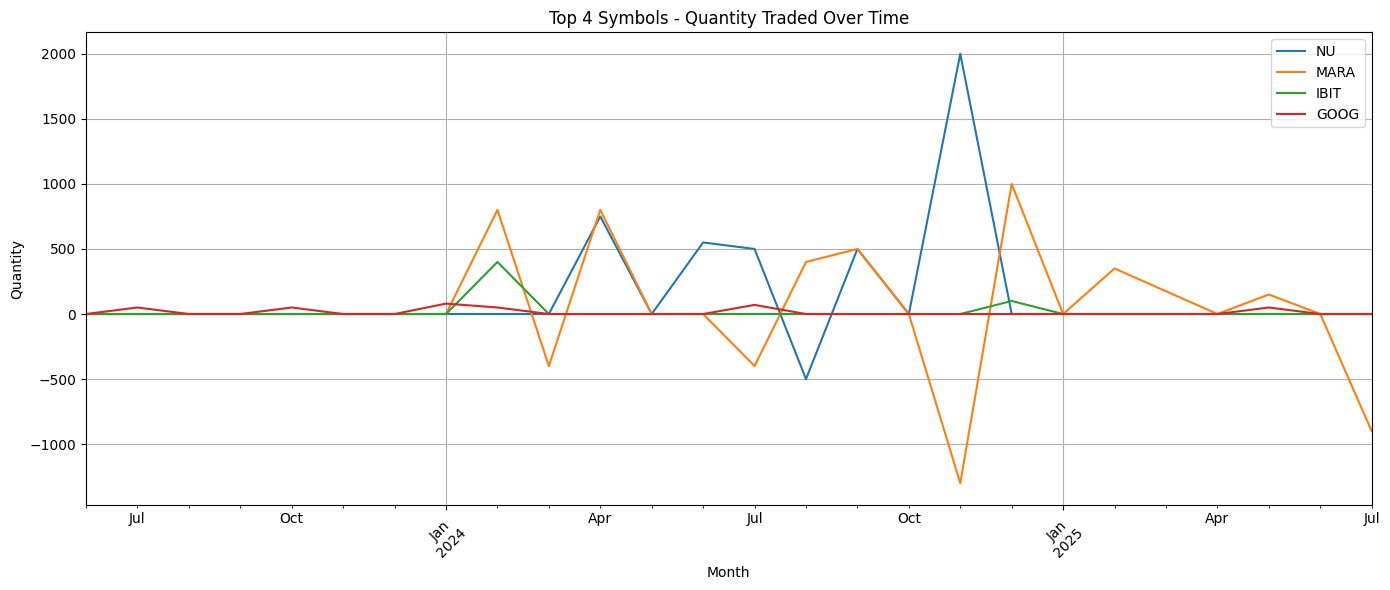

In [120]:
import matplotlib.pyplot as plt

# Get top N symbols by total traded quantity
top_symbols = quantity_traded.sum(axis=1).sort_values(ascending=False).head(4).index

plt.figure(figsize=(14, 6))
for symbol in top_symbols:
    quantity_traded.loc[symbol].plot(label=symbol)
    
plt.title("Top 4 Symbols - Quantity Traded Over Time")
plt.ylabel("Quantity")
plt.xlabel("Month")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


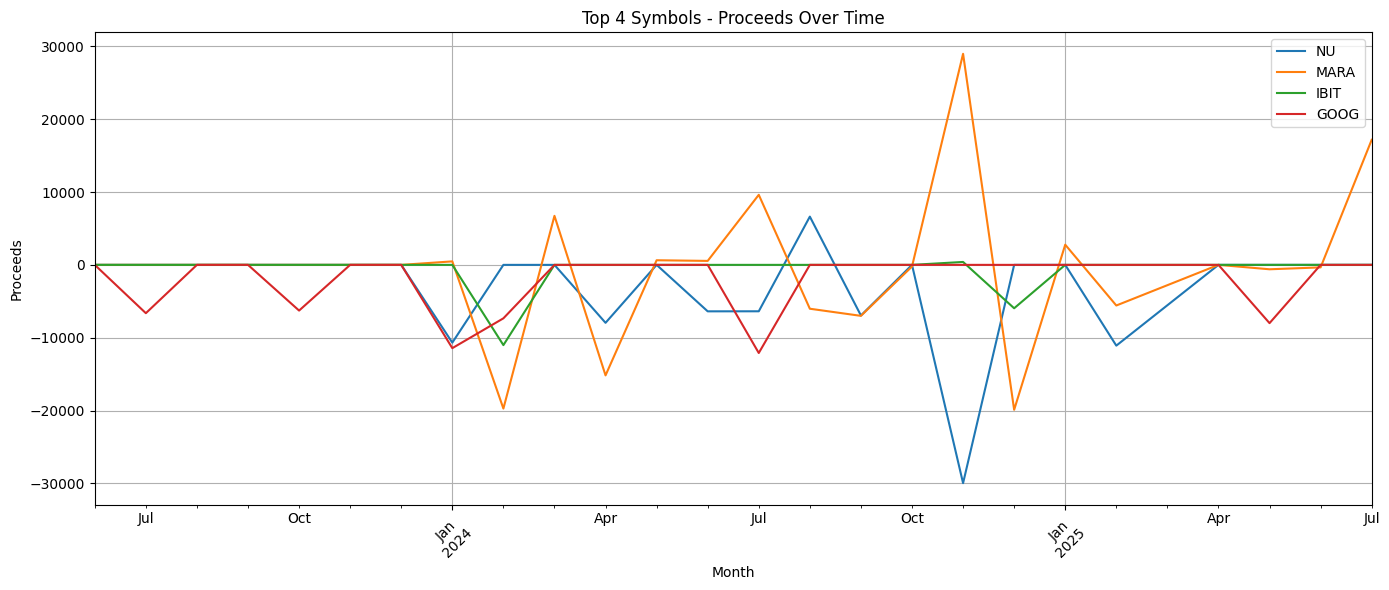

In [121]:
plt.figure(figsize=(14, 6))
for symbol in top_symbols:
    if symbol in proceeds.index:
        proceeds.loc[symbol].plot(label=symbol)
        
plt.title("Top 4 Symbols - Proceeds Over Time")
plt.ylabel("Proceeds")
plt.xlabel("Month")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


#### 4. Transform input files to reflect split-adjusted price and quantity. It needs to be done iteratively based on the split date. Adjust trading cashflow as adjusted price × adjusted quantity.

In [122]:
def calculate_adjusted_proceeds(row):
    # Always use absolute quantity
    gross = abs(row['Quantity']) * row['T. Price']
    
    # Match sign of Proceeds
    return round(gross if row['Proceeds'] > 0 else -gross, 2)


adjusted_df['Adjusted Proceeds'] = adjusted_df.apply(calculate_adjusted_proceeds, axis=1)
adjusted_df['Proceeds Diff'] = (adjusted_df['Adjusted Proceeds'] - adjusted_df['Proceeds']).round(2)
mismatch_df = adjusted_df[adjusted_df['Proceeds Diff'].abs() > 0.01]
print("Mismatched Proceeds Count:", len(mismatch_df))



Mismatched Proceeds Count: 0


In [124]:
adjusted_df.to_csv("split_adjusted_trades.csv", index=False)


#### 5. Get historical daily currency pairing for each date (USD, INR, SGD) 

In [125]:
import requests
import time

def get_fx_rate(from_currency, to_currency, date_str):
    if from_currency == to_currency:
        return 1.0
    url = f"https://api.exchangerate.host/{date_str}?base={from_currency}&symbols={to_currency}"
    response = requests.get(url)
    data = response.json()
    return data.get('rates', {}).get(to_currency)



In [126]:
base_currency = 'USD'
adjusted_df['DateStr'] = adjusted_df['Date/Time'].dt.strftime('%Y-%m-%d')

fx_cache = {}

def fetch_fx(row):
    from_curr = row['Currency']
    to_curr = base_currency
    date = row['DateStr']
    key = (from_curr, to_curr, date)
    
    if key in fx_cache:
        return fx_cache[key]
    
    rate = get_fx_rate(from_curr, to_curr, date)
    fx_cache[key] = rate
    return rate

adjusted_df['FX Rate to USD'] = adjusted_df.apply(fetch_fx, axis=1)
adjusted_df['Price in USD'] = adjusted_df['T. Price'] * adjusted_df['FX Rate to USD']
adjusted_df['Proceeds in USD'] = adjusted_df['Quantity'] * adjusted_df['Price in USD']


In [127]:
adjusted_df.head()

,Trades,Header,DataDiscriminator,Asset Category,Currency,Symbol,Date/Time,Quantity,T. Price,C. Price,...,Basis,Realized P/L,MTM P/L,Code,Adjusted Proceeds,Proceeds Diff,DateStr,FX Rate to USD,Price in USD,Proceeds in USD
0,Trades,Data,Order,Stocks,USD,AMZN,2023-07-21 13:57:21,50.0,130.478,130.00,...,6524.9780,0.0,-23.90,O,-6523.90,0.0,2023-07-21,1.0,130.478,6523.90
1,Trades,Data,Order,Stocks,USD,AMZN,2023-09-19 13:30:46,20.0,136.710,137.63,...,2735.2792,0.0,18.40,O;P,-2734.20,0.0,2023-09-19,1.0,136.710,2734.20
36,Trades,Data,Order,Stocks,USD,AMZN,2024-01-09 12:08:06,40.0,151.010,151.37,...,6041.4900,0.0,14.40,O,-6040.40,0.0,2024-01-09,1.0,151.010,6040.40
37,Trades,Data,Order,Stocks,USD,AMZN,2024-04-29 10:04:22,60.0,179.977,180.96,...,10799.7100,0.0,58.98,O,-10798.62,0.0,2024-04-29,1.0,179.977,10798.62
2,Trades,Data,Order,Stocks,USD,GOOG,2023-07-31 13:11:02,50.0,132.660,133.11,...,6634.0780,0.0,22.50,O,-6633.00,0.0,2023-07-31,1.0,132.660,6633.00


#### 6. Compute transaction price in each currency

In [128]:
import yfinance as yf

def get_adjusted_prices(symbol, start_date, end_date):
    try:
        df = yf.download(symbol, start=start_date, end=end_date, auto_adjust=False, progress=False)
        
        # Check and only extract if 'Adj Close' is present
        if 'Adj Close' not in df.columns:
            print(f"❌ 'Adj Close' missing for {symbol}")
            return pd.DataFrame()
        
        df = df[['Adj Close']].rename(columns={'Adj Close': symbol})
        return df
    except Exception as e:
        print(f"❌ Error fetching {symbol}: {e}")
        return pd.DataFrame()


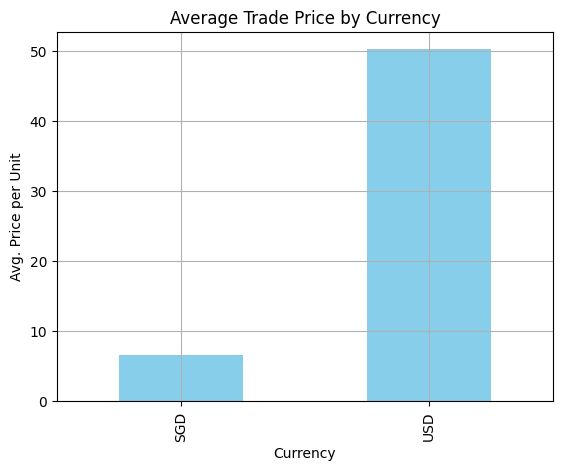

In [129]:
avg_price = adjusted_df.groupby('Currency')['T. Price'].mean().sort_values()

avg_price.plot(kind='bar', color='skyblue')
plt.title("Average Trade Price by Currency")
plt.ylabel("Avg. Price per Unit")
plt.xlabel("Currency")
plt.grid(True)
plt.show()


In [131]:
import pandas as pd

symbols = adjusted_df['Symbol'].unique()
start_date = adjusted_df['Date/Time'].min().strftime('%Y-%m-%d')
end_date = adjusted_df['Date/Time'].max().strftime('%Y-%m-%d')

price_data = pd.DataFrame()

for symbol in symbols:
    df = get_adjusted_prices(symbol, start_date, end_date)
    if df.empty:
        continue
    if price_data.empty:
        price_data = df
    else:
        price_data = price_data.join(df, how='outer')



1 Failed download:
['C6L']: YFTzMissingError('possibly delisted; no timezone found')


In [132]:
price_data.to_csv("historical_prices.csv")


#### 7.	Get split adjusted historical prices / NAVs of the stocks / mutual funds through yahoo finance / amfi

In [133]:
price_data.head()


Price,AMZN,GOOG,GPRO,MSFT,NET,NVDA,SE,SPY,TSLA,AAPL,AXP,CMG,GOOGL,IBIT,MARA,NU,ORCL
Ticker,AMZN,GOOG,GPRO,MSFT,NET,NVDA,SE,SPY,TSLA,AAPL,AXP,CMG,GOOGL,IBIT,MARA,NU,ORCL
Date,,,,,,,,,,,,,,,,,
2023-06-01,122.769997,123.635086,4.13,327.487640,69.650002,39.741425,57.980000,409.362976,207.520004,178.304764,158.288681,41.646599,122.982437,NaN,9.99,6.83,103.117668
2023-06-02,124.250000,124.490013,4.29,330.264496,70.639999,39.298744,59.389999,415.282928,213.970001,179.156235,163.969620,41.244598,123.926765,NaN,10.03,6.97,103.020378
2023-06-05,125.300003,125.881737,4.23,330.796234,69.910004,39.142860,58.599998,414.487030,217.610001,177.799835,162.870407,41.487598,125.258774,NaN,9.19,6.92,104.032188
2023-06-06,126.610001,127.154175,4.37,328.570831,68.620003,38.626232,61.279999,415.389587,221.309998,177.433487,167.140869,41.162399,126.551041,NaN,10.08,7.13,104.197586
2023-06-07,121.230003,122.213547,4.31,318.428558,62.779999,37.451946,60.970001,413.953339,224.570007,176.057281,166.878204,40.458000,121.769699,NaN,9.55,7.39,102.397713


In [134]:
import pandas as pd

symbols = adjusted_df['Symbol'].unique()
start_date = adjusted_df['Date/Time'].min().strftime('%Y-%m-%d')
end_date = adjusted_df['Date/Time'].max().strftime('%Y-%m-%d')

price_data = pd.DataFrame()
valid_symbols = []

for symbol in symbols:
    df = get_adjusted_prices(symbol, start_date, end_date)
    if df.empty:
        continue
    valid_symbols.append(symbol)
    price_data = df if price_data.empty else price_data.join(df, how='outer')



1 Failed download:
['C6L']: YFTzMissingError('possibly delisted; no timezone found')


In [135]:
price_data.head()

Price,AMZN,GOOG,GPRO,MSFT,NET,NVDA,SE,SPY,TSLA,AAPL,AXP,CMG,GOOGL,IBIT,MARA,NU,ORCL
Ticker,AMZN,GOOG,GPRO,MSFT,NET,NVDA,SE,SPY,TSLA,AAPL,AXP,CMG,GOOGL,IBIT,MARA,NU,ORCL
Date,,,,,,,,,,,,,,,,,
2023-06-01,122.769997,123.635086,4.13,327.487640,69.650002,39.741425,57.980000,409.362976,207.520004,178.304764,158.288681,41.646599,122.982437,NaN,9.99,6.83,103.117668
2023-06-02,124.250000,124.490013,4.29,330.264496,70.639999,39.298744,59.389999,415.282928,213.970001,179.156235,163.969620,41.244598,123.926765,NaN,10.03,6.97,103.020378
2023-06-05,125.300003,125.881737,4.23,330.796234,69.910004,39.142860,58.599998,414.487030,217.610001,177.799835,162.870407,41.487598,125.258774,NaN,9.19,6.92,104.032188
2023-06-06,126.610001,127.154175,4.37,328.570831,68.620003,38.626232,61.279999,415.389587,221.309998,177.433487,167.140869,41.162399,126.551041,NaN,10.08,7.13,104.197586
2023-06-07,121.230003,122.213547,4.31,318.428558,62.779999,37.451946,60.970001,413.953339,224.570007,176.057281,166.878204,40.458000,121.769699,NaN,9.55,7.39,102.397713


#### 8.	Compute daily portfolio value across currencies. Portfolio value = Quantity * price, summed for all holdings

In [149]:
# Ensure Date is clean (no time component)
adjusted_df['Trade Date'] = pd.to_datetime(adjusted_df['Date/Time'].dt.date)

# Step 1: Sort and compute cumulative quantity
adjusted_df_sorted = adjusted_df.sort_values(by=['Symbol', 'Trade Date'])

# Step 2: Group by Symbol and Date, sum quantity for that day
daily_trades = adjusted_df_sorted.groupby(['Trade Date', 'Symbol'])['Quantity'].sum().reset_index()

# Step 3: Pivot to get daily net trades
daily_trades_pivot = daily_trades.pivot(index='Trade Date', columns='Symbol', values='Quantity').fillna(0)

# Step 4: Cumulative sum = holdings
holdings_pivot = daily_trades_pivot.cumsum()

# Step 5: Align with price_data index
holdings_pivot = holdings_pivot.reindex(price_data.index).fillna(method='ffill').fillna(0)

# Double check
print(holdings_pivot.head())


Symbol      AAPL  AMZN  AXP  C6L  CMG  GOOG  GOOGL  GPRO  IBIT  MARA  MSFT  \
Date                                                                         
2023-06-01   0.0   0.0  0.0  0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   
2023-06-02   0.0   0.0  0.0  0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   
2023-06-05   0.0   0.0  0.0  0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   
2023-06-06   0.0   0.0  0.0  0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   
2023-06-07   0.0   0.0  0.0  0.0  0.0   0.0    0.0   0.0   0.0   0.0   0.0   

Symbol        NET   NU   NVDA  ORCL   SE  SPY  TSLA  
Date                                                 
2023-06-01  100.0  0.0    0.0   0.0  0.0  0.0   0.0  
2023-06-02  100.0  0.0    0.0   0.0  0.0  0.0   0.0  
2023-06-05  100.0  0.0    0.0   0.0  0.0  0.0   0.0  
2023-06-06  100.0  0.0    0.0   0.0  0.0  0.0   0.0  
2023-06-07  100.0  0.0  400.0   0.0  0.0  0.0   0.0  


C:\Users\Tanvi\AppData\Local\Temp\ipykernel_11272\3354017035.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  holdings_pivot = holdings_pivot.reindex(price_data.index).fillna(method='ffill').fillna(0)


In [150]:
holdings_pivot.sum().sum()  # should be > 0


np.float64(2130165.0)

In [151]:
print("Holdings symbols:", holdings_pivot.columns.tolist())
print("Price data symbols:", price_data.columns.tolist())


Holdings symbols: ['AAPL', 'AMZN', 'AXP', 'C6L', 'CMG', 'GOOG', 'GOOGL', 'GPRO', 'IBIT', 'MARA', 'MSFT', 'NET', 'NU', 'NVDA', 'ORCL', 'SE', 'SPY', 'TSLA']
Price data symbols: [('AMZN', 'AMZN'), ('GOOG', 'GOOG'), ('GPRO', 'GPRO'), ('MSFT', 'MSFT'), ('NET', 'NET'), ('NVDA', 'NVDA'), ('SE', 'SE'), ('SPY', 'SPY'), ('TSLA', 'TSLA'), ('AAPL', 'AAPL'), ('AXP', 'AXP'), ('CMG', 'CMG'), ('GOOGL', 'GOOGL'), ('IBIT', 'IBIT'), ('MARA', 'MARA'), ('NU', 'NU'), ('ORCL', 'ORCL')]


In [153]:
# Flatten any MultiIndex columns to simple strings
price_data.columns = [col if isinstance(col, str) else col[0] for col in price_data.columns]

print("Aligned symbols:", holdings_pivot.columns.intersection(price_data.columns).tolist())


Aligned symbols: ['AAPL', 'AMZN', 'AXP', 'CMG', 'GOOG', 'GOOGL', 'GPRO', 'IBIT', 'MARA', 'MSFT', 'NET', 'NU', 'NVDA', 'ORCL', 'SE', 'SPY', 'TSLA']


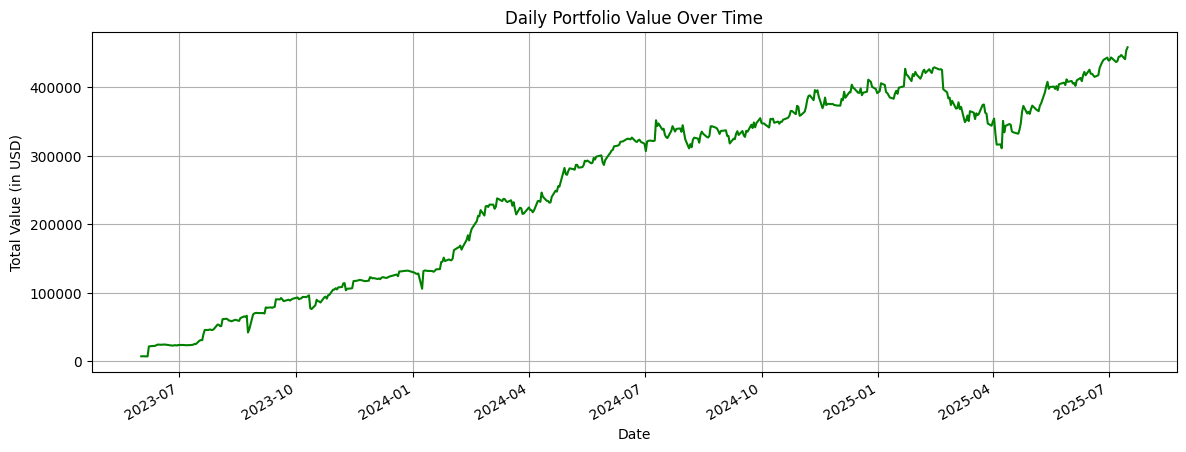

In [154]:
aligned_symbols = holdings_pivot.columns.intersection(price_data.columns)

# Compute daily values
daily_stock_values = holdings_pivot[aligned_symbols] * price_data[aligned_symbols]
daily_stock_values['Total Value'] = daily_stock_values.sum(axis=1)

# Plot
daily_stock_values['Total Value'].plot(figsize=(14, 5), color='green')
plt.title("Daily Portfolio Value Over Time")
plt.ylabel("Total Value (in USD)")
plt.xlabel("Date")
plt.grid(True)
plt.show()


#### 9.	Compute XIRR for each holding

In [155]:
import numpy as np
import numpy_financial as npf
from datetime import datetime

def compute_xirr(cash_flows):
    dates = list(cash_flows.keys())
    values = list(cash_flows.values())

    if not values or all(v == 0 for v in values):
        return None

    days = [(date - dates[0]).days / 365 for date in dates]
    irr = npf.irr(values)

    if irr is None:
        return None
    return irr



In [156]:
valid_symbols = price_data.columns

xirr_results = {}

for symbol in adjusted_df['Symbol'].unique():
    if symbol not in valid_symbols:
        xirr_results[symbol] = "Skipped (no price data)"
        continue

    df = adjusted_df[adjusted_df['Symbol'] == symbol].copy()
    df = df[df['Proceeds'] != 0]

    cash_flows = {}

    for _, row in df.iterrows():
        date = row['Date/Time'].date()
        proceeds = row['Proceeds']
        cash_flows[date] = cash_flows.get(date, 0) + proceeds

    # Add terminal value (if holding any)
    last_price = price_data.loc[price_data.index.max(), symbol]
    last_quantity = holdings_pivot.loc[price_data.index.max(), symbol]
    if last_quantity != 0:
        cash_flows[price_data.index.max().date()] = cash_flows.get(price_data.index.max().date(), 0) + (last_price * last_quantity)

    # Compute XIRR
    try:
        xirr_results[symbol] = compute_xirr(cash_flows)
    except Exception as e:
        xirr_results[symbol] = f"Error: {e}"


In [157]:
for sym, val in xirr_results.items():
    print(f"{sym}: {val:.2%}" if isinstance(val, float) else f"{sym}: {val}")


AMZN: 17.56%
GOOG: 5.86%
GPRO: -53.85%
MSFT: 14.88%
NET: 54.09%
NVDA: nan%
SE: 94.59%
SPY: 2.62%
TSLA: 9.92%
C6L: Skipped (no price data)
AAPL: 3.45%
AXP: 36.71%
CMG: nan%
GOOGL: -2.40%
IBIT: 21.34%
MARA: 0.52%
NU: -6.59%
ORCL: 30.50%


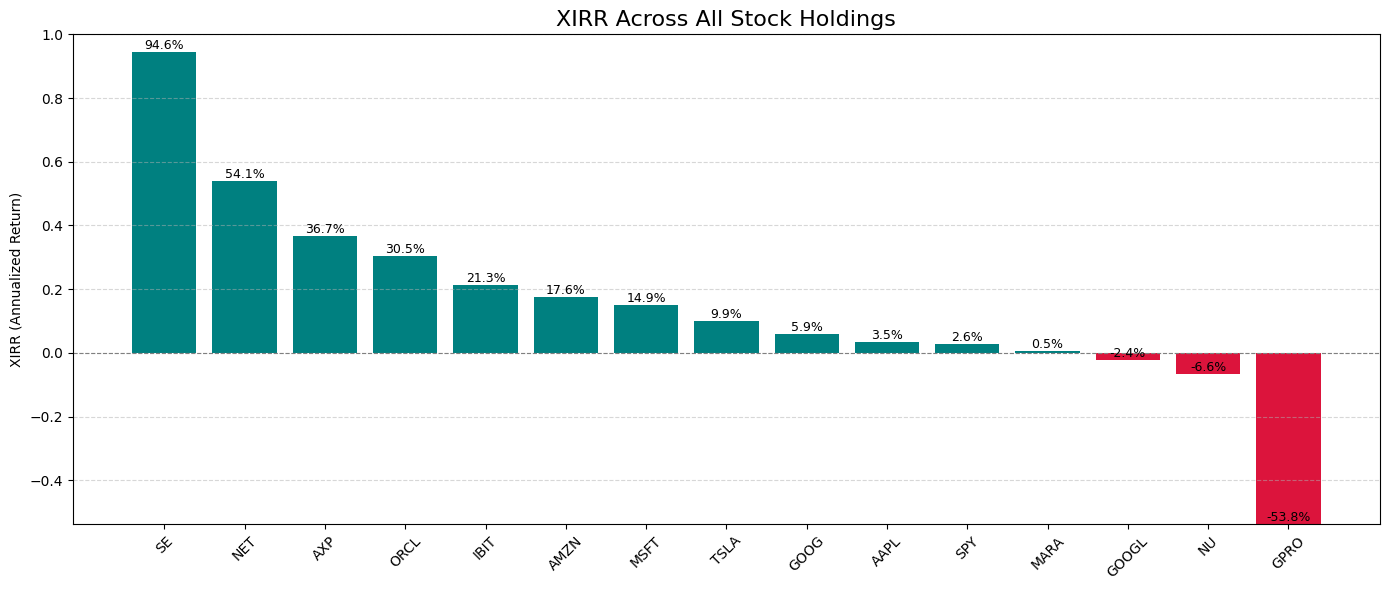

In [158]:
import matplotlib.pyplot as plt
import numpy as np

# Filter valid XIRR values only (skip NaN, None, "Skipped")
filtered_results = {
    sym: rate for sym, rate in xirr_results.items()
    if isinstance(rate, (float, int)) and not np.isnan(rate)
}

# Sort by XIRR value (optional, for clarity)
sorted_xirr = dict(sorted(filtered_results.items(), key=lambda item: item[1], reverse=True))

# Prepare data
symbols = list(sorted_xirr.keys())
xirr_values = list(sorted_xirr.values())

# Color by positive/negative return
colors = ['teal' if val >= 0 else 'crimson' for val in xirr_values]

# Plot
plt.figure(figsize=(14, 6))
bars = plt.bar(symbols, xirr_values, color=colors)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.title("XIRR Across All Stock Holdings", fontsize=16)
plt.ylabel("XIRR (Annualized Return)")
plt.xticks(rotation=45)
plt.ylim(min(min(xirr_values), -0.5), max(max(xirr_values), 1.0))  # Clamp range for readability
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Optional: Add percentage labels on top of each bar
for bar, val in zip(bars, xirr_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f"{val:.1%}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [160]:
import joblib
import os

# Create 'data/' folder if it doesn't exist
os.makedirs("data", exist_ok=True)

# Save your precomputed data
joblib.dump(adjusted_df, "data/adjusted_df.pkl")
joblib.dump(price_data, "data/price_data.pkl")
joblib.dump(holdings_pivot, "data/holdings_pivot.pkl")
joblib.dump(daily_stock_values, "data/daily_stocks_value.pkl")
joblib.dump(xirr_results, "data/xirr_results.pkl")


['data/xirr_results.pkl']